# Shapelets and the Shapelet Transform with sktime

[Github weblink](https://github.com/alan-turing-institute/sktime/blob/master/examples/shapelet_transform.ipynb)

Introduced in [1], a shapelet is a time series subsequences that is identified as being representative of class membership. Shapelets are a powerful approach for measuring _phase-independent_ similarity between time series; they can occur at any point within a series and offer _interpretable_ results for how matches occur. The original research extracted shapelets to build a decision tree classifier. As an example, the top shapelet from the <a href="http://timeseriesclassification.com/description.php?Dataset=GunPoint">GunPoint</a> problem found in [1] is shown below (the shapelet is highlighted in red):  

![shapelet gun point](img/shapelets_gun_point.PNG)

The GunPoint problem contains univariate tracking data of actor's wrists as they either take a prop gun from a holster, point it, and return it to the holster, or they simply mime the action without the prop. The classification problem is to detect whether a motion trace is a case of _gun_ or _no gun_. The most discriminatory shapelet shown above offers an interpretable result into how classification decisions can be made; the highlighted red section of the series above is the shapelet and it occurs when an actor returns the gun to the holster. As explained in [1], this is discriminatory because if the gun prop is present then the actor's hand stops suddenly, but if the prop is not present, the actor's hand will not stop abruptly and will subtly continue past their waist due to inertia. 

## The Shapelet Transform

Much research emphasis has been placed on shapelet-based approaches for time series classification (TSC) since the original research was proposed. The current state-of-the-art for shapelets is the **shapelet transform** (ST) [2, 3]. The transform improves upon the original use of shapelets by separating shapelet extraction from the classification algorithm, allowing interpretable phase-independent classification of time series with any standard classification algorithm (such as random/rotation forest, neural networks, nearest neighbour classifications, ensembles of all, etc.). To facilitate this, rather than recursively assessing data for the best shapelet, the transform evaluates candidate shapelets in a single procedure to rank them based on information gain. Then, given a set of _k_ shapelets, a time series can be transformed into _k_ features by calculating the distance from the series to each shapelet. By transforming a dataset in this manner any vector-based classification algorithm can be applied to a shapelet-transformed time series problem while the interpretability of shapelets is maintained through the ranked list of the _best_ shapelets during transformation. An example of the interpretability offered from ST is shown below with the top 10 shapelets extracted from the GunPoint problem in [2]:

![shapelets gun point transform](img/shapelets_gun_point_transform.PNG)

The image above demonstrates that there are two clear groupings of shapelets: one where the gun is placed into the holster, as in [1], but also one where the gun is removed from the holster. It would be a reasonable assumption that if placing the prob back into the holster is discriminatory then removing it from the holster should also be; this was not detected in the original research but is explicitly identified by using the shapelet transform. 

#### References
[1] Ye, Lexiang, and Eamonn Keogh. "Time series shapelets: a novel technique that allows accurate, interpretable and fast classification." Data mining and knowledge discovery 22, no. 1-2 (2011): 149-182.

[2] Lines, Jason, Luke M. Davis, Jon Hills, and Anthony Bagnall. "A shapelet transform for time series classification." In Proceedings of the 18th ACM SIGKDD international conference on Knowledge discovery and data mining, pp. 289-297. ACM, 2012.

[3] Hills, Jon, Jason Lines, Edgaras Baranauskas, James Mapp, and Anthony Bagnall. "Classification of time series by shapelet transformation." Data Mining and Knowledge Discovery 28, no. 4 (2014): 851-881.

[4] Bostrom, Aaron, and Anthony Bagnall. "Binary shapelet transform for multiclass time series classification." In Transactions on Large-Scale Data-and Knowledge-Centered Systems XXXII, pp. 24-46. Springer, Berlin, Heidelberg, 2017.

## Example: The Shapelet Transform in sktime  

The following workbook demonstrates a full workflow of using the shapelet transform in `sktime` with a `scikit-learn` classifier with the GunPoint problem. 



In [1]:
from sktime.datasets import load_gunpoint
from sktime.transformers.shapelets import ContractedShapeletTransform

train_x, train_y = load_gunpoint(split='TRAIN', return_X_y=True)
test_x, test_y = load_gunpoint(split='TEST', return_X_y=True)

In [2]:
# How long (in minutes) to extract shapelets for.
# This is a simple lower-bound initially; once time is up, no further shapelets will be assessed
time_limit_in_mins = 0.1

# The initial number of shapelet candidates to assess per training series. If all series are visited
# and time remains on the contract then another pass of the data will occur 
initial_num_shapelets_per_case = 10

# Whether or not to print on-going information about shapelet extraction. Useful for demo/debugging
verbose = 2

st = ContractedShapeletTransform(
    time_limit_in_mins=time_limit_in_mins, 
    num_candidates_to_sample_per_case=initial_num_shapelets_per_case, 
    verbose=verbose)
st.fit(train_x, train_y)

visiting series: 15 (#1)
Candidate finished. 00:05 remaining
Candidate finished. 00:05 remaining
Candidate finished. 00:05 remaining
Candidate finished. 00:05 remaining
Candidate rejected. 00:04 remaining
Candidate finished. 00:04 remaining
Candidate finished. 00:04 remaining
Candidate finished. 00:04 remaining
Candidate finished. 00:03 remaining
Candidate finished. 00:03 remaining
visiting series: 4 (#2)
Candidate finished. 00:03 remaining
Candidate finished. 00:03 remaining
Candidate finished. 00:03 remaining
Candidate finished. 00:03 remaining
Candidate finished. 00:02 remaining
Candidate finished. 00:02 remaining
Candidate finished. 00:02 remaining
Candidate finished. 00:02 remaining
Candidate finished. 00:01 remaining
Candidate finished. 00:01 remaining
visiting series: 24 (#3)
Candidate finished. 00:01 remaining
Candidate finished. 00:01 remaining
Candidate finished. 00:01 remaining
Candidate finished. 00:01 remaining
Candidate finished. 00:00 remaining
Candidate rejected. 00:00 

Series ID: 15, start_pos: 75, length: 74, info_gain: 0.6504518266138437, 


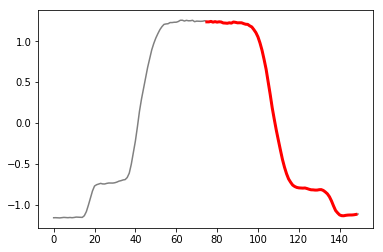

Series ID: 24, start_pos: 100, length: 17, info_gain: 0.40883397854940606, 


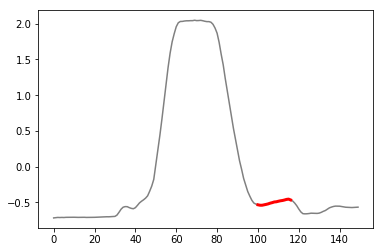

Series ID: 4, start_pos: 9, length: 83, info_gain: 0.3582289761063985, 


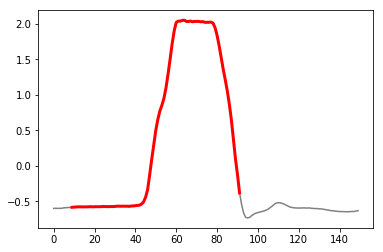

Series ID: 24, start_pos: 67, length: 4, info_gain: 0.2747133107726767, 


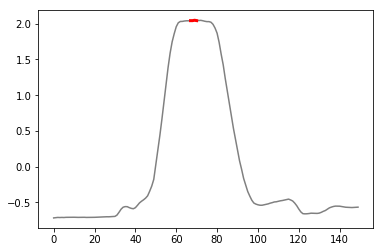

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# for each extracted shapelet (in descending order of quality/information gain)
for s in st.shapelets[0:5]:

    # summary info about the shapelet 
    print(s)
    
    # plot the series that the shapelet was extracted from 
    plt.plot(
        train_x.iloc[s.series_id,0],
        'gray'
    )
    
    # overlay the shapelet onto the full series
    plt.plot(
        list(range(s.start_pos,(s.start_pos+s.length))),
        train_x.iloc[s.series_id,0][s.start_pos:s.start_pos+s.length],
        'r',
        linewidth=3.0
    )
    plt.show()

#0: Series ID: 15, start_pos: 75, length: 74, info_gain: 0.6504518266138437, 
#1: Series ID: 24, start_pos: 100, length: 17, info_gain: 0.40883397854940606, 
#2: Series ID: 4, start_pos: 9, length: 83, info_gain: 0.3582289761063985, 
#3: Series ID: 24, start_pos: 67, length: 4, info_gain: 0.2747133107726767, 


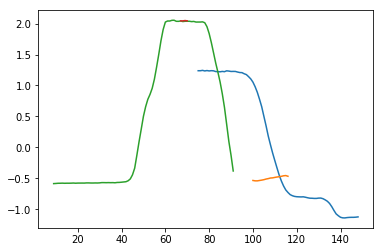

In [4]:
# for each extracted shapelet (in descending order of quality/information gain)
for i in range(0,min(len(st.shapelets),5)):
    s = st.shapelets[i]
    # summary info about the shapelet 
    print("#"+str(i)+": "+str(s))
    
    # overlay shapelets
    plt.plot(
        list(range(s.start_pos,(s.start_pos+s.length))),
        train_x.iloc[s.series_id,0][s.start_pos:s.start_pos+s.length]
    )

plt.show()

In [5]:
import time
import numpy as np
from sktime.datasets import load_gunpoint
from sktime.transformers.shapelets import ContractedShapeletTransform
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.pipeline import Pipeline

np.random.seed(seed=0)
train_x, train_y = load_gunpoint(split='TRAIN', return_X_y=True)
test_x, test_y = load_gunpoint(split='TEST', return_X_y=True)

# example pipleine with 1 minute time limit
pipeline = Pipeline([
    ('st', ContractedShapeletTransform(time_limit_in_mins=0.1, 
                                       num_candidates_to_sample_per_case=10, 
                                       verbose=False)),
    ('rf', RandomForestClassifier(n_estimators=100)),
])

start = time.time()
pipeline.fit(train_x, train_y)
end_build = time.time()
preds = pipeline.predict(test_x)
end_test = time.time()

print("Results:")
print("Correct:")
correct = sum(preds == test_y)
print("\t"+str(correct)+"/"+str(len(test_y)))
print("\t"+str(correct/len(test_y)))
print("\nTiming:")
print("\tTo build:   "+str(end_build-start)+" secs")
print("\tTo predict: "+str(end_test-end_build)+" secs")

Results:
Correct:
	143/150
	0.9533333333333334

Timing:
	To build:   6.9595160484313965 secs
	To predict: 3.520045042037964 secs
